К нам пришли с запросом оценить расходы на маркетинг развлекательного приложения Procrastinate Pro+. 

# Цель исследования 
Найти причину неэффективности рекламы и дать советы как это можно исправить


# Ход работы
1.Загрузить данные и подготовьте их к дальнейшему анализу

2.Задать функции для расчёта и анализа LTV, ROI, удержания и конверсии

3.Провести исследовательский анализ данных

4.Провести маркетинговый анализ

5.Оцените окупаемость рекламы

6.Написать выводы


### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
from datetime import date, timedelta


In [2]:
#загрузим файлы
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'),  # журнал визитов
    pd.read_csv('/datasets/orders_info.csv'),  # заказы
    pd.read_csv('/datasets/costs_info.csv')  # расходы
)

Первым рассмотрим файл с визитами 

#### Визиты

In [3]:
print('-------------------------------------------------------------------')
visits.info()
print('-------------------------------------------------------------------')
display(visits.head(5))
print('-------------------------------------------------------------------')
print('Явные дубли:', visits.duplicated().sum())
print('-------------------------------------------------------------------')
display(visits.describe())
print('-------------------------------------------------------------------')
display(visits.isna().sum())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
-------------------------------------------------------------------


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


-------------------------------------------------------------------
Явные дубли: 0
-------------------------------------------------------------------


,User Id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


-------------------------------------------------------------------


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

-------------------------------------------------------------------


У нас не оказалось полных дублей и пропусков, что радует, но есть, что исправить:
 - изменим для Session Start и Session End тип данных и обрежем ее
 - для Region, Device, Channel на строковый
 - скорректируем названия столбцов

In [4]:
# названия
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]

# время
visits['session_start'] = pd.to_datetime(visits['session_start'], format="%d.%m.%Y %H:%M")
visits['session_end'] = pd.to_datetime(visits['session_end'], format="%d.%m.%Y %H:%M")
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

# тип
visits['region'] = visits['region'].astype(str)
visits['device'] = visits['device'].astype(str)
visits['channel'] = visits['channel'].astype(str)

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


#### Заказы

In [5]:
print('-------------------------------------------------------------------')
orders.info()
print('-------------------------------------------------------------------')
display(orders.head(5))
print('-------------------------------------------------------------------')
print('Явные дубли:', orders.duplicated().sum())
print('-------------------------------------------------------------------')
display(orders.describe())
print('-------------------------------------------------------------------')
display(orders.isna().sum())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
-------------------------------------------------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


-------------------------------------------------------------------
Явные дубли: 0
-------------------------------------------------------------------


,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


-------------------------------------------------------------------


User Id     0
Event Dt    0
Revenue     0
dtype: int64

-------------------------------------------------------------------


По файлу Заказы получились примерно аналогичные выводы.

Дублей и пропусков не найдено, но исправляем:

 - изменим для Event dt тип данных и обрежем ее
  
 - скорректируем названия столбцов

In [6]:
# названия
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]

# время
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format="%Y-%m-%d %H:%M:%S")
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


#### Расходы

In [7]:
print('-------------------------------------------------------------------')
costs.info()
print('-------------------------------------------------------------------')
display(costs.head(5))
print('-------------------------------------------------------------------')
print('Явные дубли:', costs.duplicated().sum())
print('-------------------------------------------------------------------')
display(costs.describe())
print('-------------------------------------------------------------------')
display(costs.isna().sum())
print('-------------------------------------------------------------------')

-------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
-------------------------------------------------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


-------------------------------------------------------------------
Явные дубли: 0
-------------------------------------------------------------------


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


-------------------------------------------------------------------


dt         0
Channel    0
costs      0
dtype: int64

-------------------------------------------------------------------


В Расходах не нашли дублей и пропусков, исправим следующее:

 - изменим для dt тип данных и обрежем ее
 
 - для Channel на строковый
 
 - скорректируем названия столбцов

In [8]:
# названия
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

# время
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")
costs['dt'] = pd.to_datetime(costs['dt'])

# тип
costs['channel'] = costs['channel'].astype(str)

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


#### Вывод
Для всех трех датасетов не найдено явных дублей и пустых полей. Можно работать с данными.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция для создания пользовательских профилей get_profiles

In [9]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчета удержания get_retention

In [10]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчета конверсии get_conversion

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчета LTV, ROI

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция для сглаживания фрейма

In [13]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Визуализация удержания

In [14]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Визуализация конверсии

In [15]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Визуализация LTV и ROI

In [16]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 20))
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Вывод
Мы использовали все нужные функции для дальнейшего анализа даных

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.

In [17]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max() 
print('Минимальная дата привлечения {} и максимальная {}'.format(min_date, max_date))

Минимальная дата привлечения 2019-05-01 00:00:00 и максимальная 2019-10-27 00:00:00


#### Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
region_payer_share = pd.DataFrame()
region_payer_share['users_cnt'] = profiles.groupby('region')['user_id'].count()
region_payer_share['payer_users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer_share['share'] = 100*(region_payer_share['payer_users_cnt'] / region_payer_share['users_cnt'])
region_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
region,,,
United States,100002,6902,6.9%
Germany,14981,616,4.1%
UK,17575,700,4.0%
France,17450,663,3.8%


Большая доля пользователей приходит из US, а самая малочисленная группа из Франции

#### Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [20]:
device_payer_share = pd.DataFrame()
device_payer_share['users_cnt'] = profiles.groupby('device')['user_id'].count()
device_payer_share['payer_users_cnt'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer_share['share'] = 100*(device_payer_share['payer_users_cnt'] / device_payer_share['users_cnt'])
device_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
device,,,
Mac,30042,1912,6.4%
iPhone,54479,3382,6.2%
Android,35032,2050,5.9%
PC,30455,1537,5.0%


Клиенты для платежей чаще всего используют iPhone, а реже всего PC

#### Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [21]:
channel_payer_share = pd.DataFrame()
channel_payer_share['users_cnt'] = profiles.groupby('channel')['user_id'].count()
channel_payer_share['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_payer_share['share'] = 100*(channel_payer_share['payer_users_cnt'] / channel_payer_share['users_cnt']) 
channel_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
channel,,,
FaceBoom,29144,3557,12.2%
AdNonSense,3880,440,11.3%
lambdaMediaAds,2149,225,10.5%
TipTop,19561,1878,9.6%
RocketSuperAds,4448,352,7.9%
WahooNetBanner,8553,453,5.3%
YRabbit,4312,165,3.8%
MediaTornado,4364,156,3.6%
LeapBob,8553,262,3.1%


Очевидным лидером по привлечению пользователей оказался канал FaceBoom, но а organic и OppleCreativeMedia оказались на последних местах

#### Вывод
После исследования данных мы можем сказать, что:
- минимальная и максимальная даты  - 2019-05-01 и 2019-10-27
- больше всего пользователей и оплат из США, а меньше всего из Франции
- пользователи платят чаще всего с Mac, меньше оплачивают с PC
- юзеры FaceBoom чаще заинтересовываются рекламой, а organic и OppleCreativeMedia почти не привлекаются

Мы изучили данные, теперь можем понять какую маркетенговую ценность они несут для нас.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Посчитайте общую сумму расходов на маркетинг.

In [22]:
print('Общая сумма расходов:', costs['costs'].sum().round(2), 'у.е')

Общая сумма расходов: 105497.3 у.е


#### Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [23]:
costs_channel = costs.groupby('channel')['costs'].sum()
print('Траты по источникам')
print(costs_channel.sort_values(ascending=False))

Траты по источникам
channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64


Оказалось, что больше всего на рекламу тратится для TipTop, а для YRabbit самые минимальные затраты. Это можно увидеть на графике

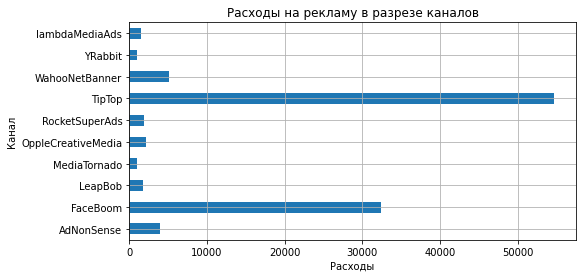

In [24]:
costs_channel.plot.barh(y='costs',
                    grid=True,title='Расходы на рекламу в разрезе каналов',
                     figsize=(8,4)).set(ylabel='Канал', 
                     xlabel='Расходы'
                      );

#### Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.

In [25]:
costs['week'] = costs['dt'].astype('datetime64[W]')

costs['month'] = costs['dt'].astype('datetime64[M]')

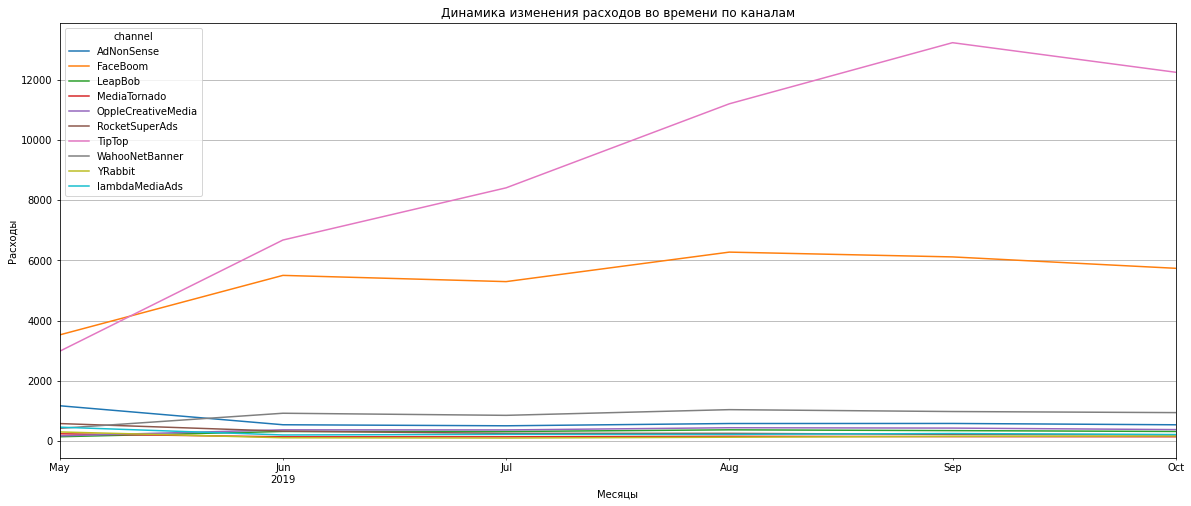

In [26]:
costs.pivot_table(
    index='month', 
    columns='channel', 
    values='costs', 
    aggfunc='sum'

).plot(figsize=(20, 8), grid=True)
plt.title('Динамика изменения расходов во времени по каналам')
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.show()

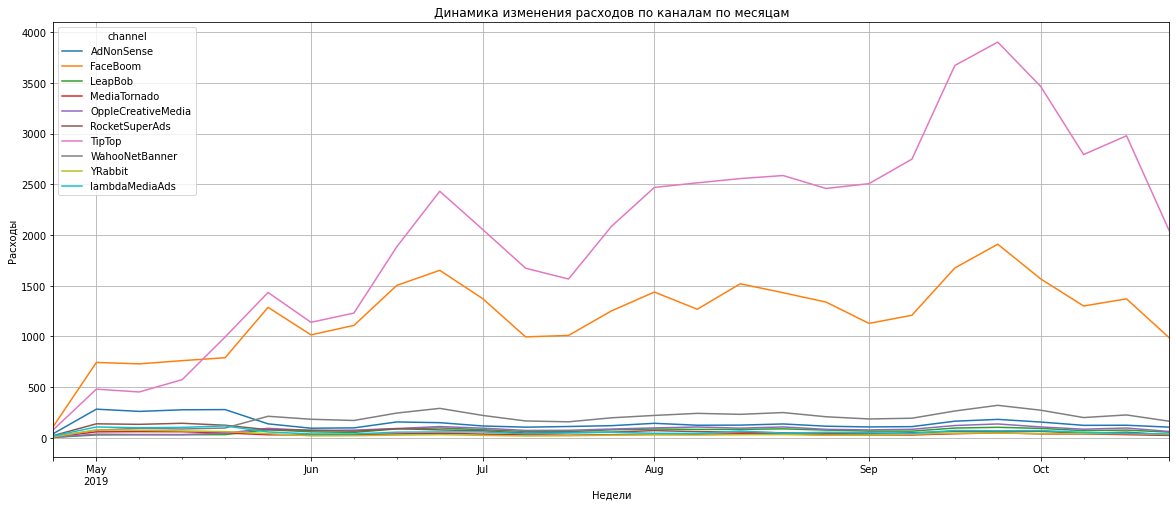

In [27]:
costs.pivot_table(
    index='week',  
    columns='channel',  
    values='costs',  
    aggfunc='sum'  

).plot(figsize=(20, 8), grid=True)
plt.title('Динамика изменения расходов по каналам по месяцам')
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.show()

На графиках по месяцам и по неделям, мы увидели, что по затратам лидируют TipTop и FaceBoom, основные траты на эти компании пришлись на Сентябрь


#### Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

In [28]:
#CAC для каждого источника
cac = pd.DataFrame()
cac['acquisition_cost_mean'] = profiles.query('channel != "organic"').groupby('channel')['acquisition_cost'].mean()
cac.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


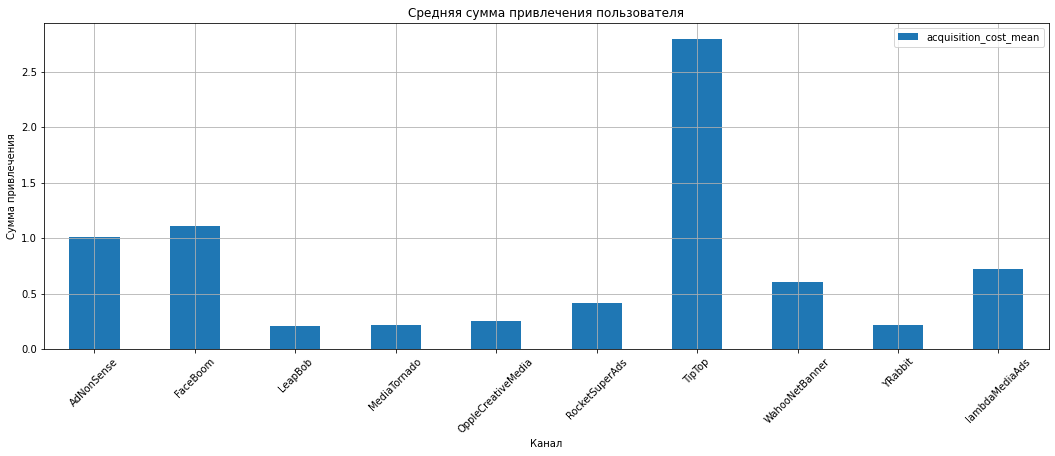

In [29]:
cac.plot.bar(
                         figsize = (18, 6), grid=True, rot=45, title='Средняя сумма привлечения пользователя').set(
                         xlabel="Канал", ylabel='Сумма привлечения');

Мы видим, что самые дорогие пользователи, по затратам на привлечение - это из TipTop. Уже LeapBob является менее затратным.

#### Вывод
Общая сумма расходов компании составляет 105497.3 у.е

При этом больше всех на рекламу тратится для TipTop, которая не является лидером, по привлечению клиентов. С другой стороны, мы видим, что траты минимальны для YRabbit, но по привлечению это не самый последний канал.

На графике по Месяцам мы видим, что два канала выбиваются по затратам - это TipTop и FaceBoom, остальные компании +- близки.
Для TipTop яркий рост выражен в период с июня по сентябрь, где превысило планку в 12000 у.е
Для FaceBoom рост более плавный, где пиковое значение в 6000 у.е
Обе компании получили небольшое снижение затрат после сентября

На графике по неделям мы видим примерно аналогичную картину, но чуть детализированнее. Например, мы видим, что по тратам на компании TipTop и FaceBoom был спад после Июля, пиковые значения приходятся ближе к Октябрю

Самое дорогое привлечение пользователя выявлено для TipTop, а далее, почти в 2 раза дешевле идет FaceBoom. Самыми минимальными тратами являются YRabbit, MediaTornado, LeapBob.				

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [30]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 


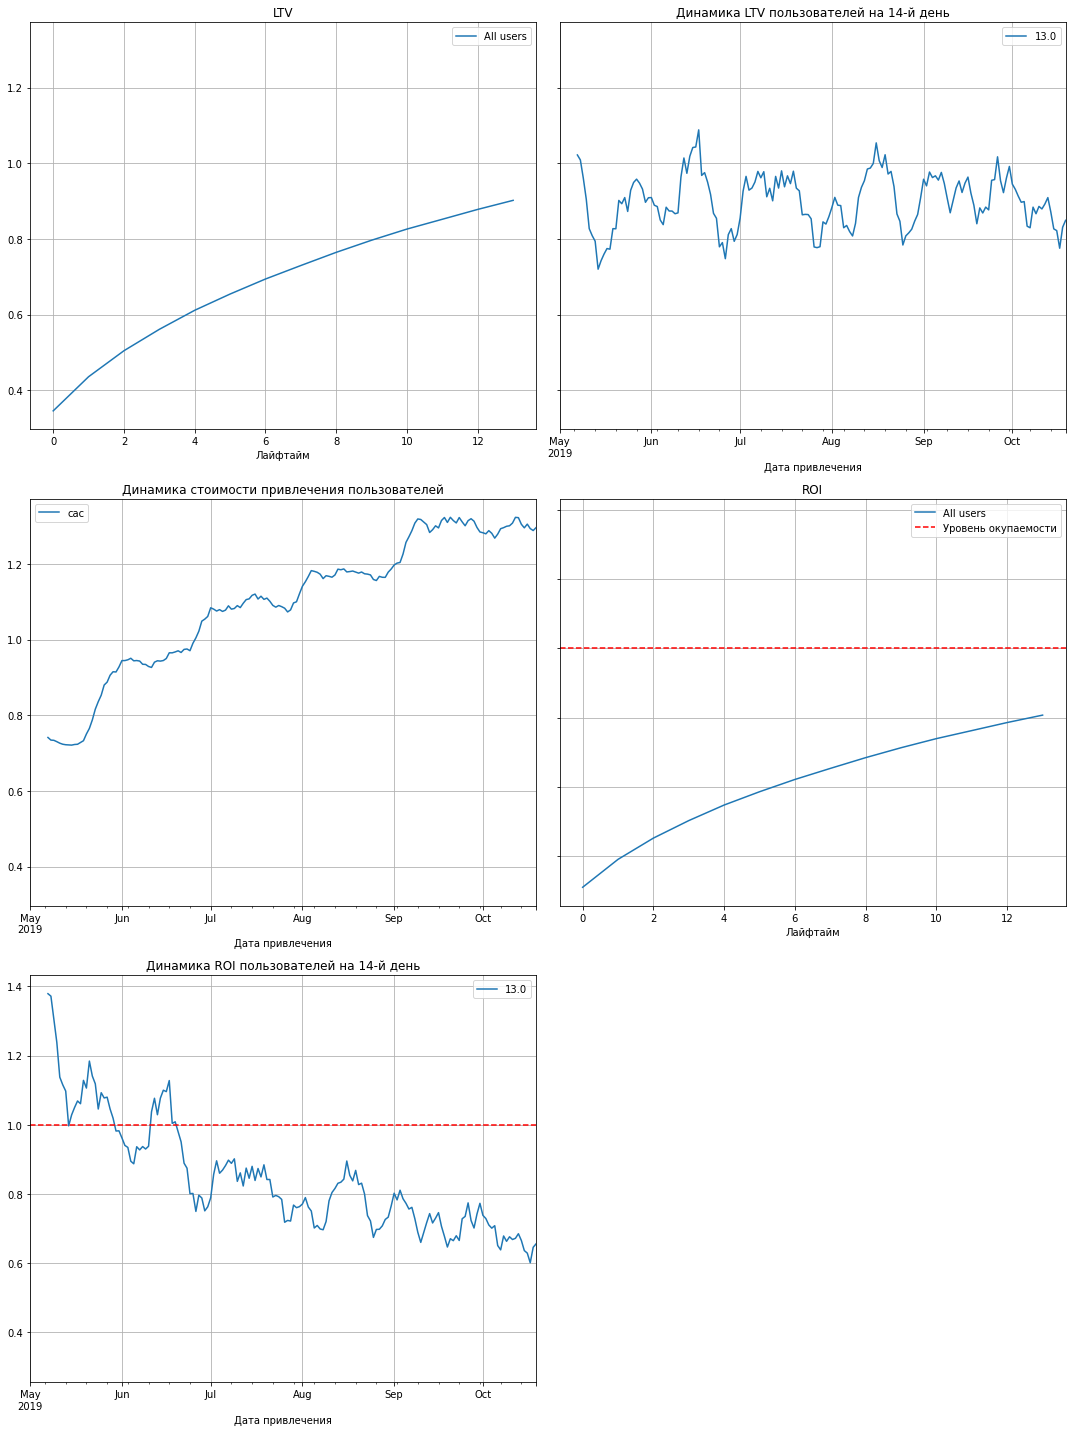

In [31]:
profiles = profiles.query('channel != "organic"')

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Вывод для графиков окупаемости:

Есть проблемы с окупаемостью к концу 2й недели.

Нет стабильности для CAC. Бюджет на рекламу растет.

LTV достаточно стабилен.

ROI пользователей заметно упал после июня.

Можно сказать, что реклама не окупается.

#### Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.

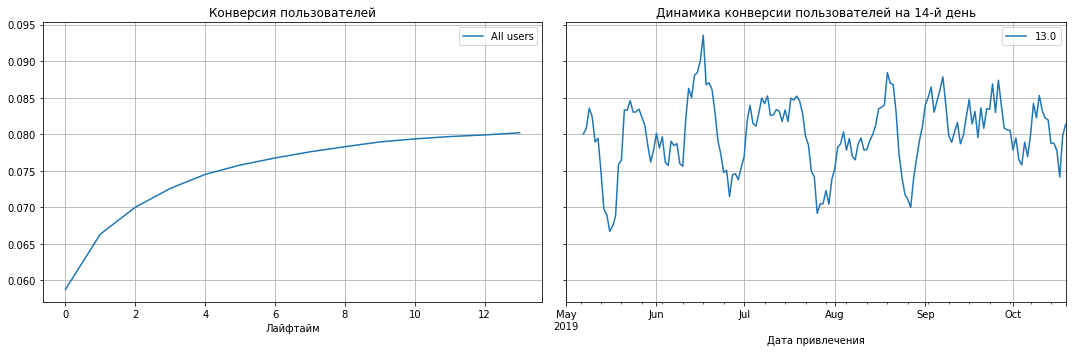

In [32]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Довольно хорошая конверсия, а динамика сезонная - в некоторые мясяца есть просадки

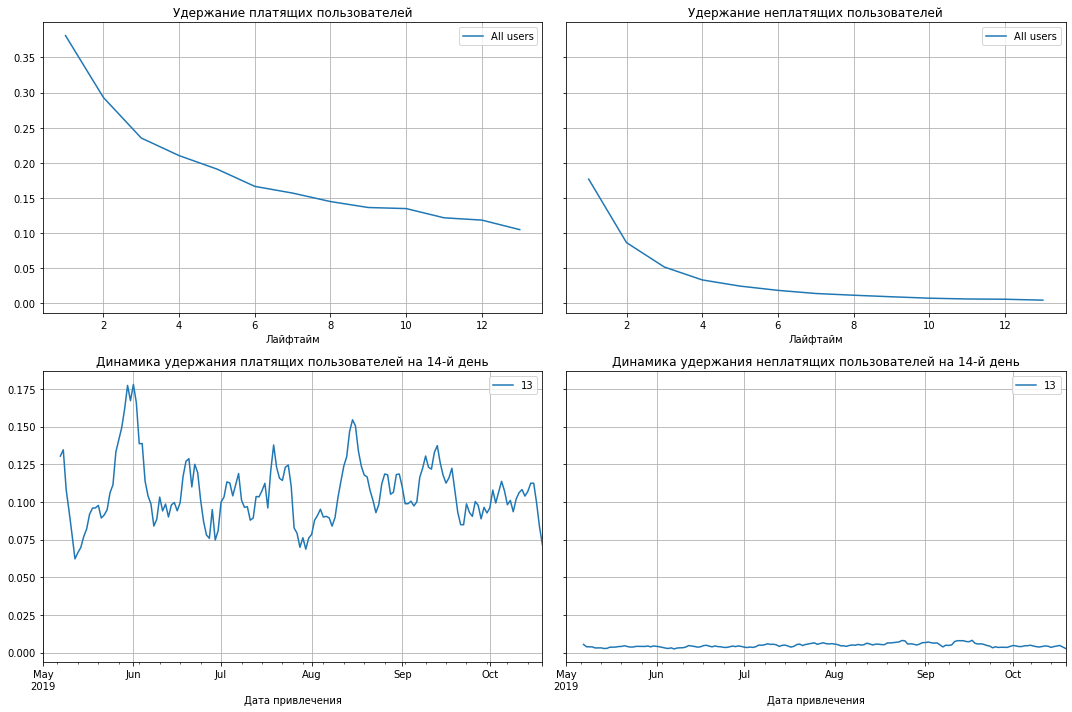

In [33]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

На графиках видны проблемы с удержанием пользователей

#### Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

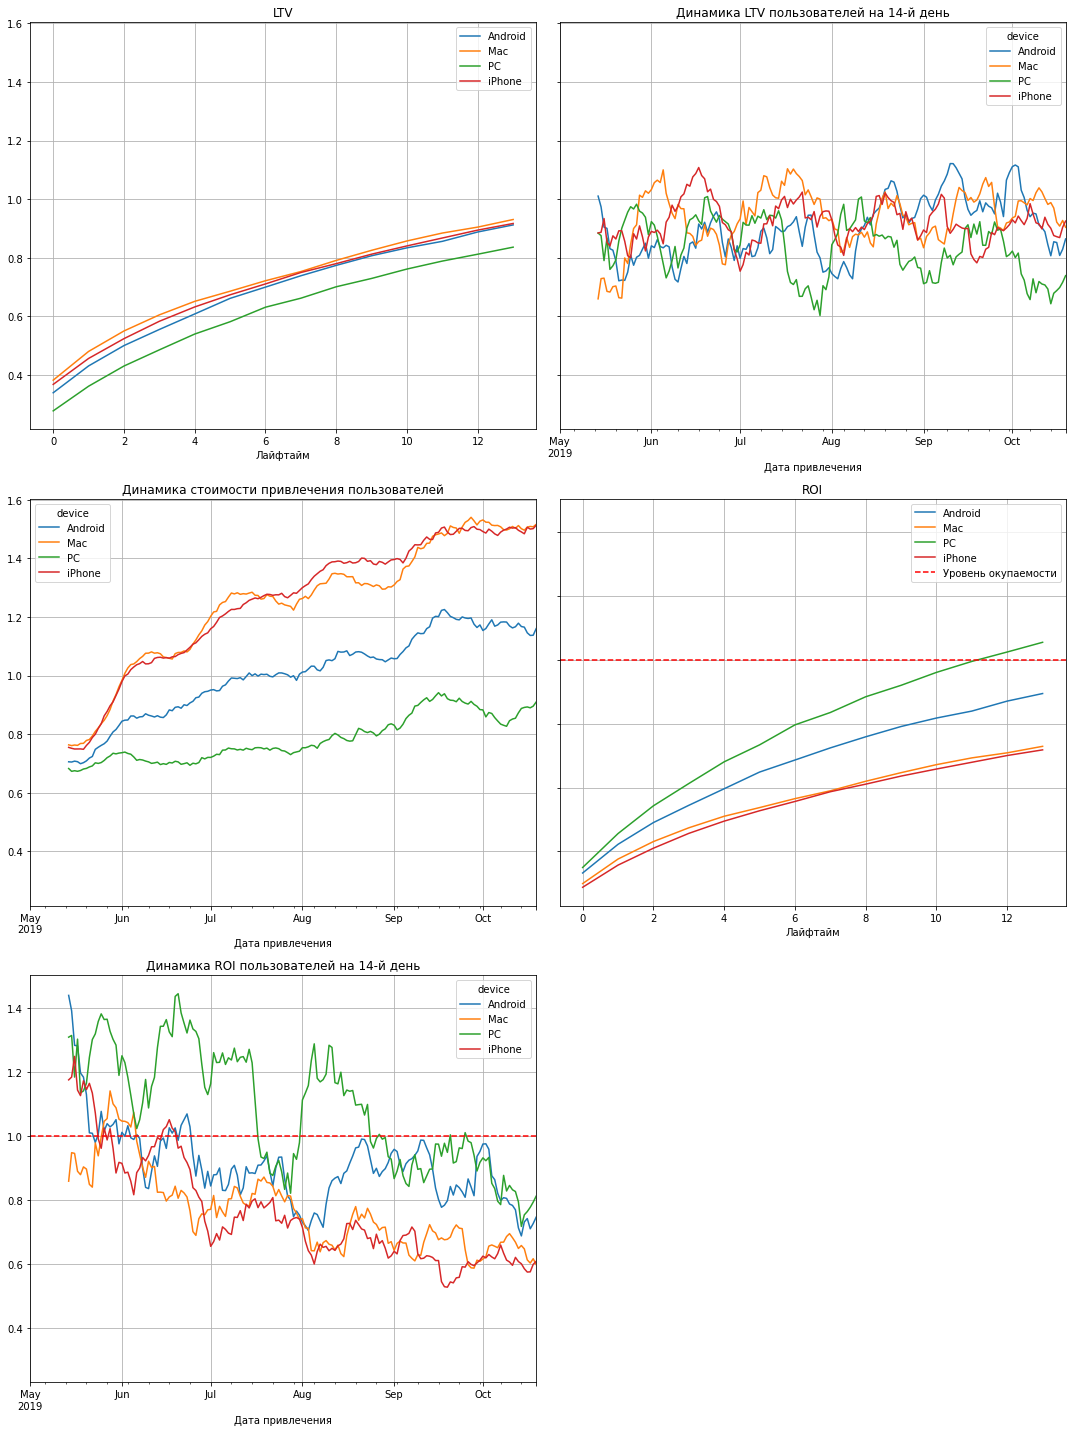

In [34]:
# Смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

LTV довольно стабильный. По графикам видно, что у PC довольно неплохие показатели - ROI превышает Уровень окупаемости, хоть и меньше всего привлечено покупателей. Например, для Mac и iPhone ROI на 14 день с июля упал по окупаемости, а расходы на их привлечение, наоборот росли в этот период. 

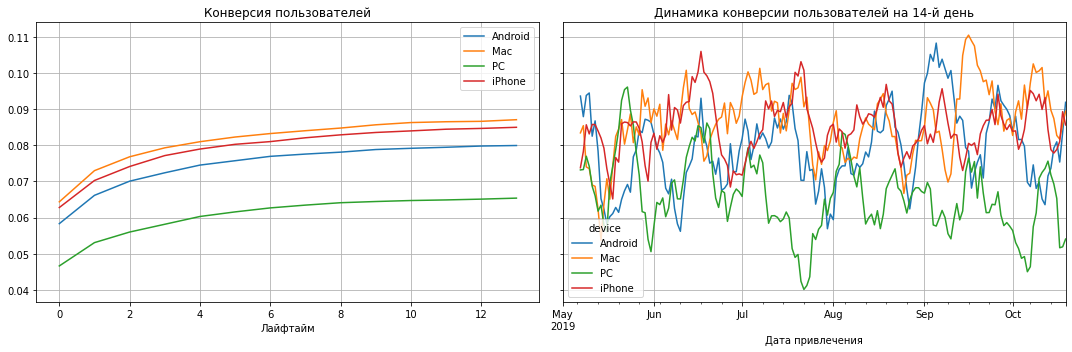

In [35]:
dimensions = ['device']
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Большие просадки по конверсии у пользователей PC и Android

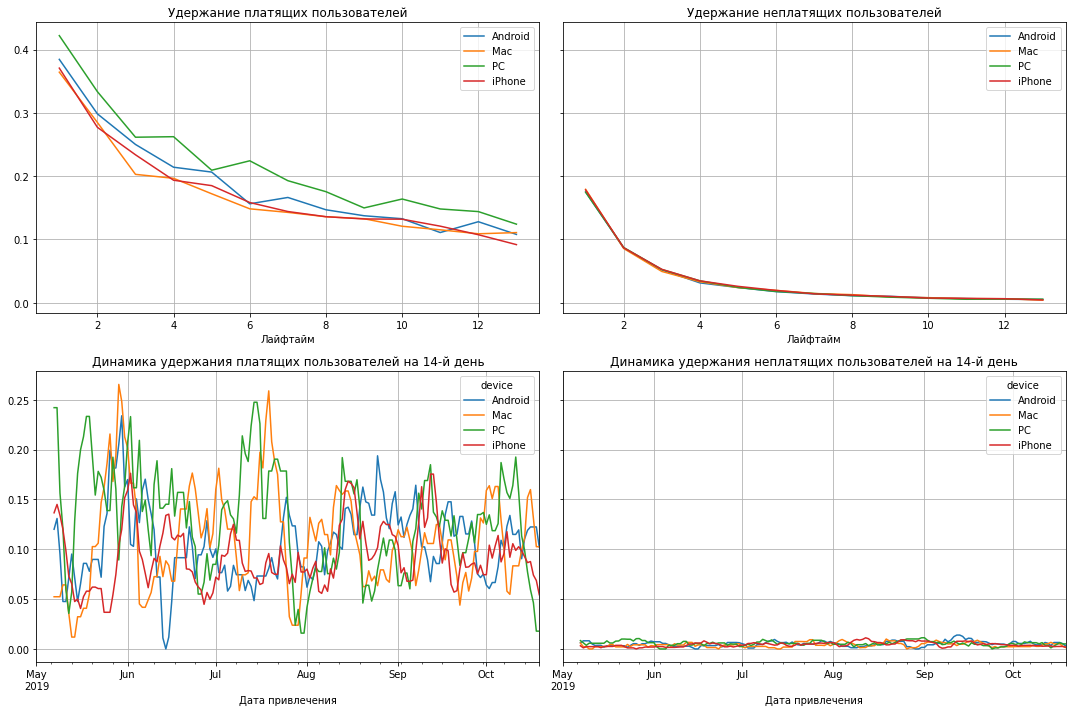

In [36]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Динамика удержания неплатящих пользователей похожа.

#### Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

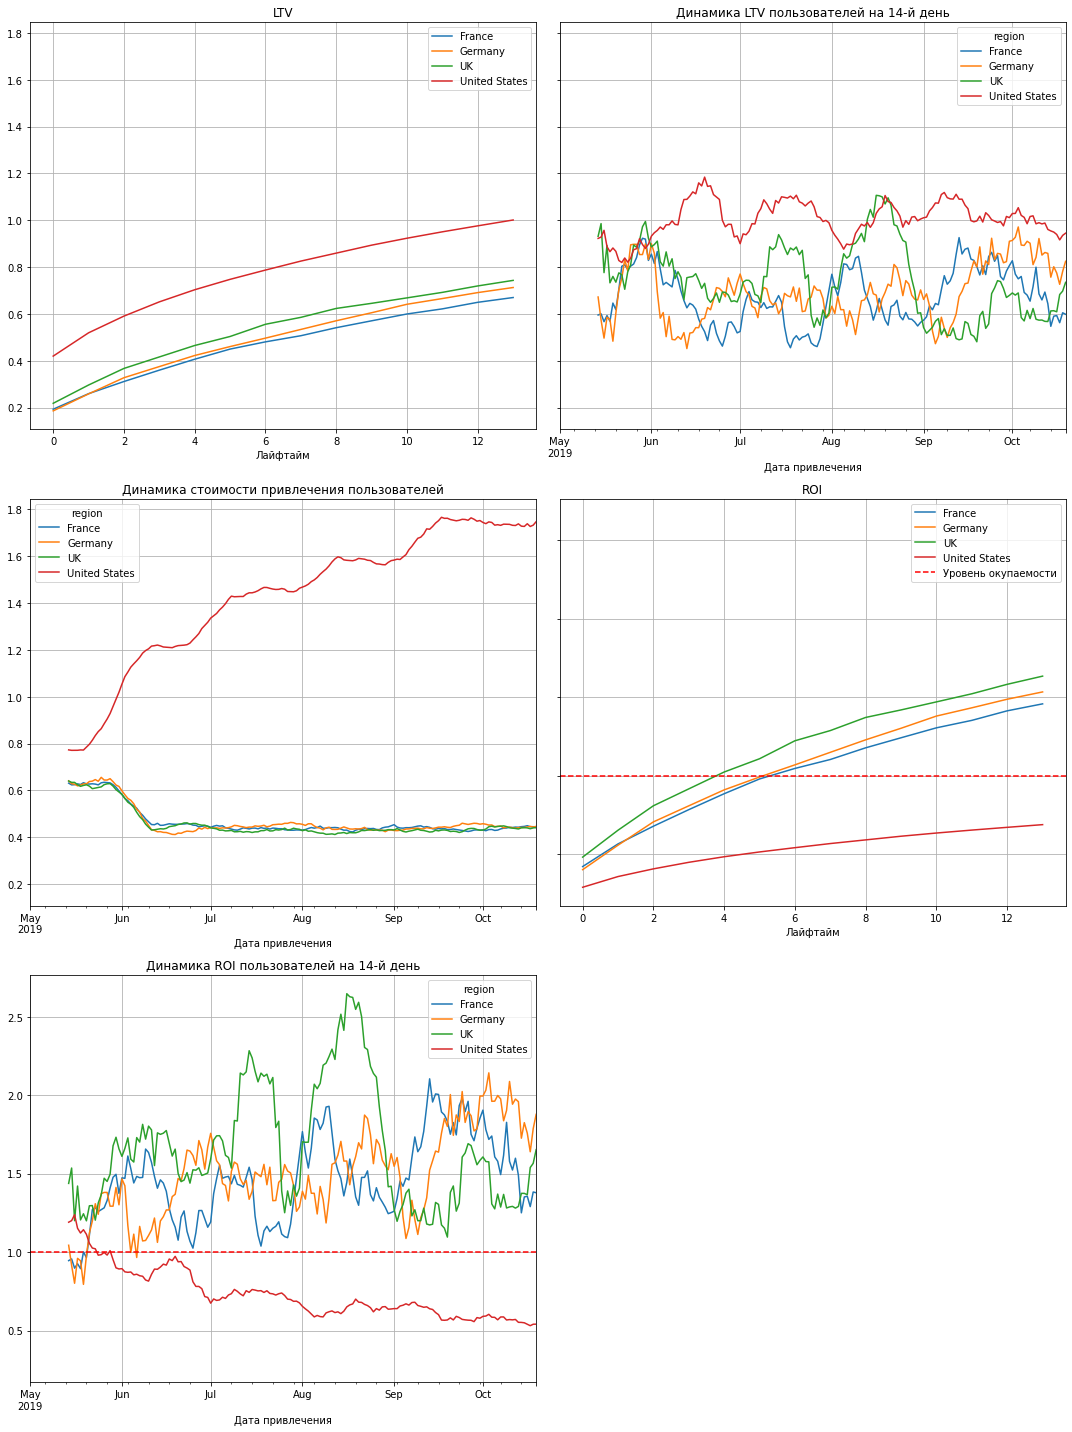

In [37]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Мы получили довольно противоречивый результат по США - американские пользователи преобладают, но реклама не окупается, а стоимость привлечения покупателей там самая высокая.

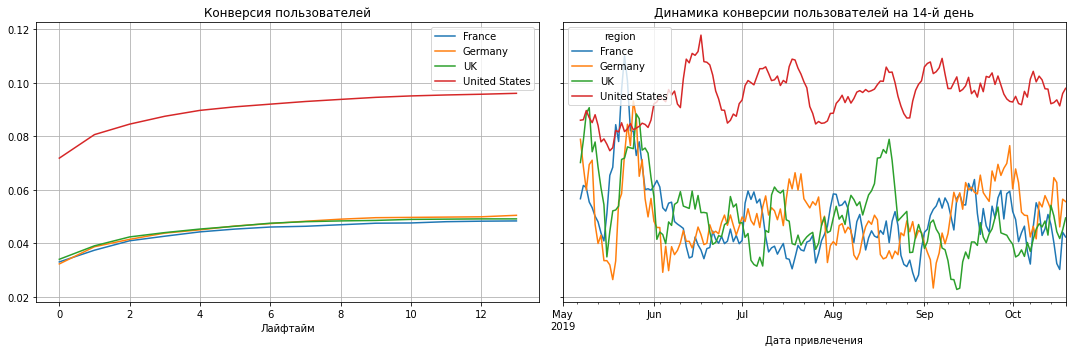

In [38]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей из США в 2 раза выше чем у пользователей из других стран

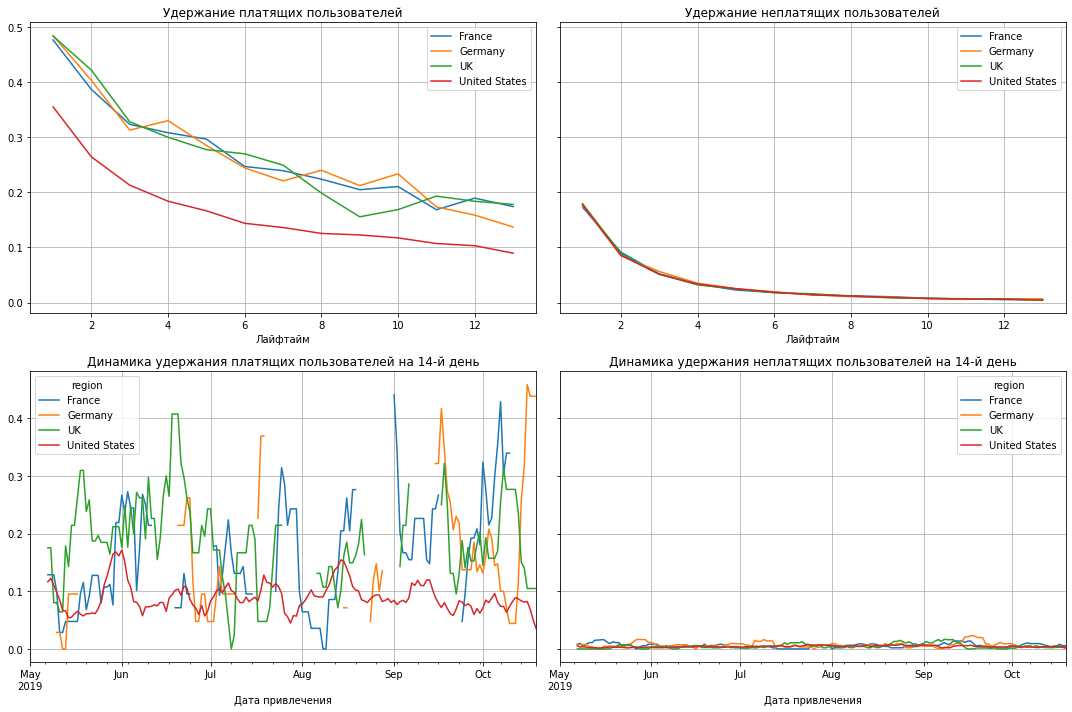

In [39]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей из США самое низкое

#### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

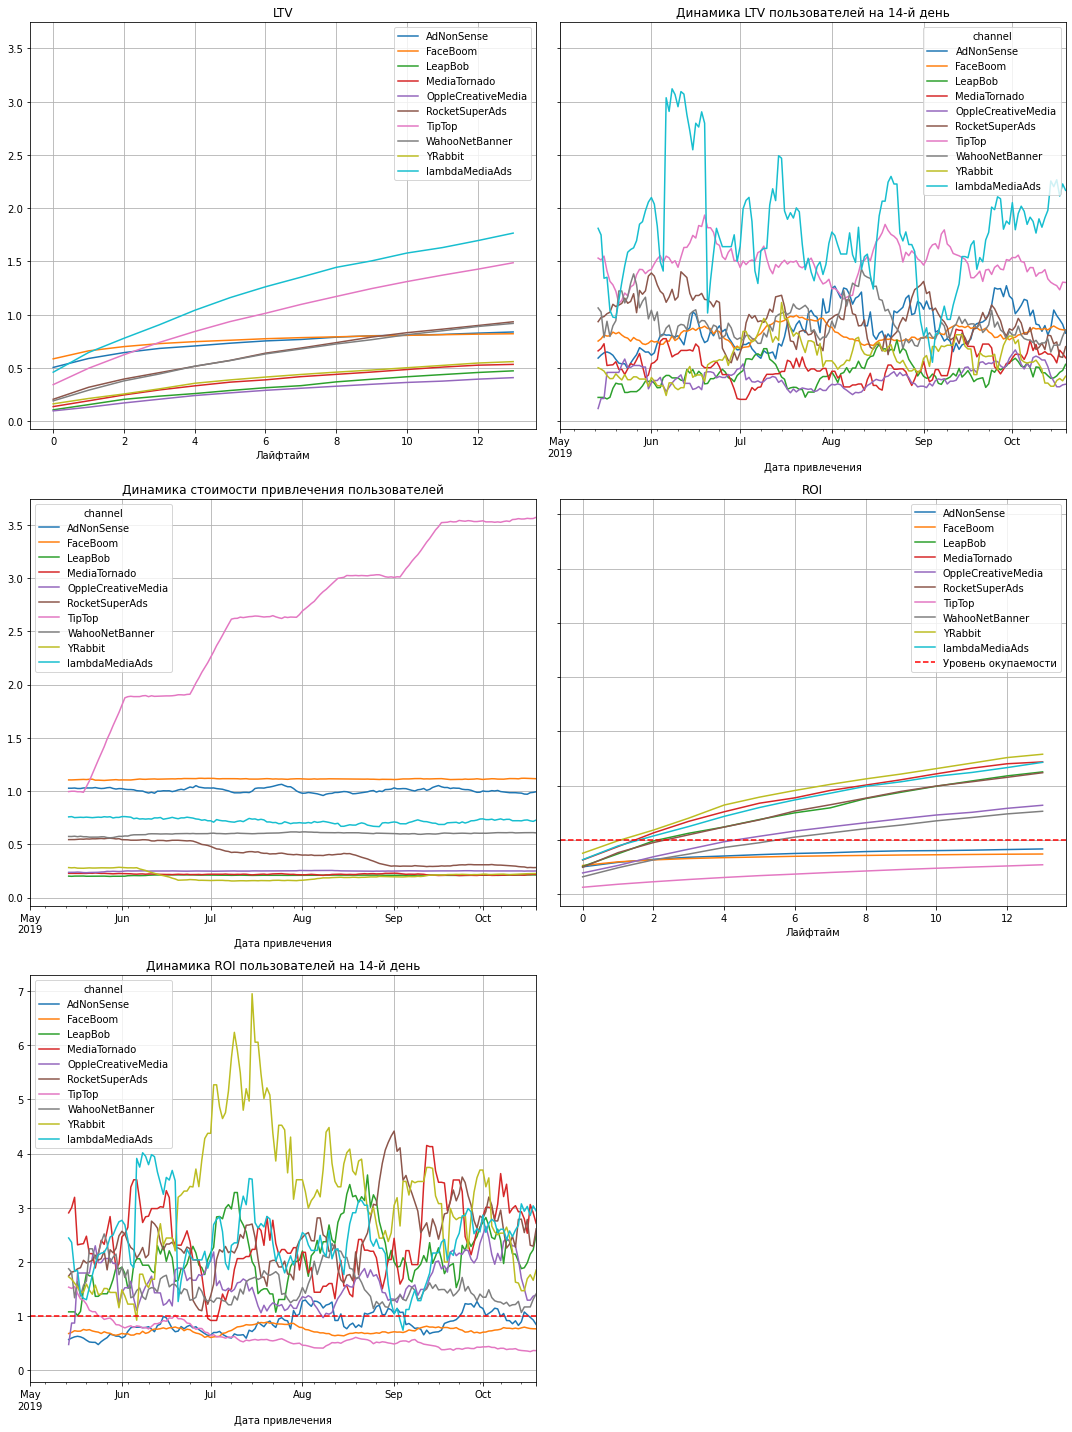

In [40]:
# проанализируем окупаемость рекламы с разбивкой по рекламным каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Для TipTop, FaceBoom, AdNonSense есть проблемы с окупаемостью, а для TipTop еще и дорогое привлечение клиентов.
YRabbit в июле оказался в топе для ROI пользователей на 14й день

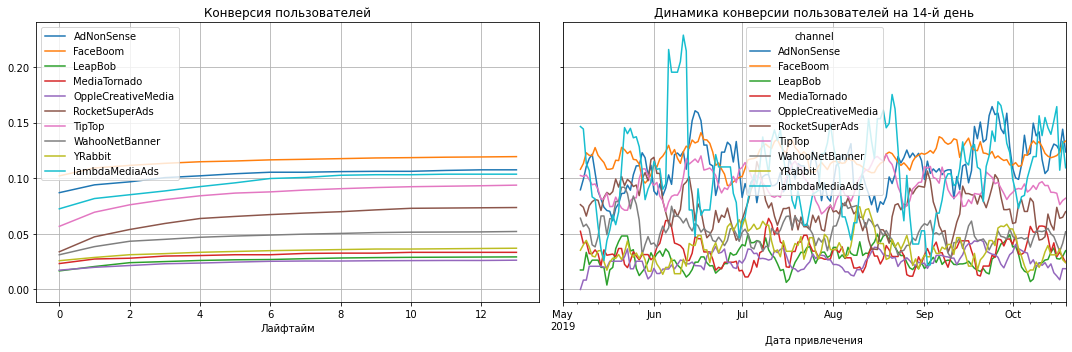

In [41]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

В конверсии пользователей из разных каналов наблюдается сезонность

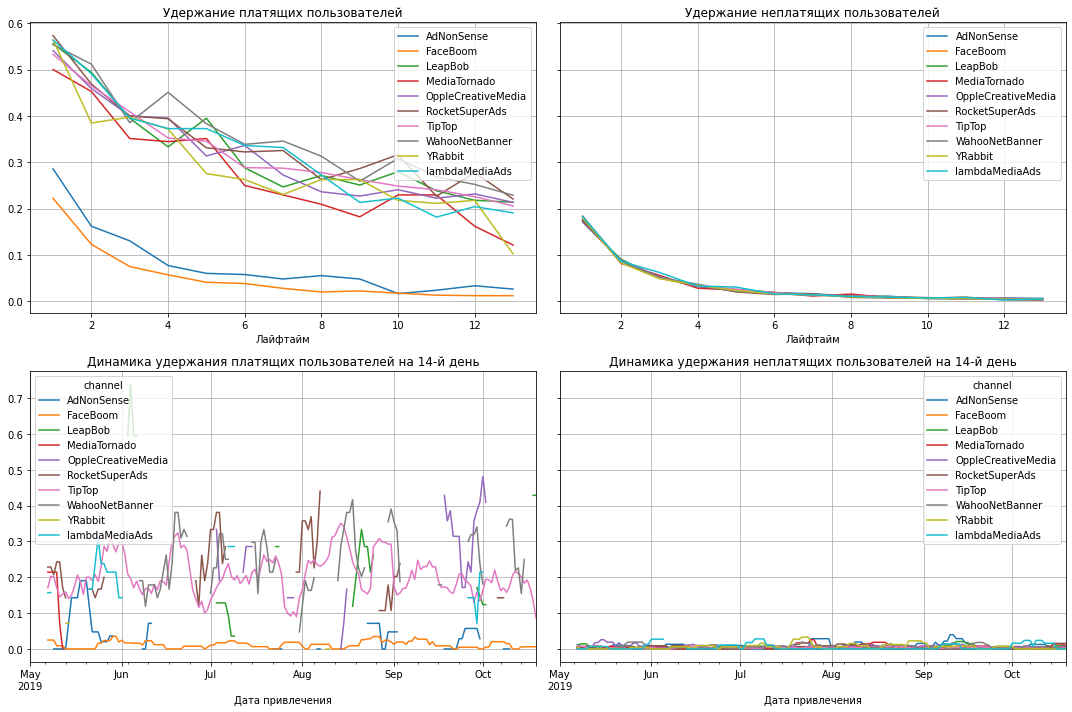

In [42]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей из каналов AdNonSense,FaceBoom самое низкое

#### Ответьте на такие вопросы:
##### Окупается ли реклама, направленная на привлечение пользователей в целом?

Мы выяснили, что окупаемость рекламы падает к концу 2й недели. ROI — около 80%.

##### Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Негативное влияние оказывают пользователи из США, т.к они плохо удерживаются. 

Довольно плохо удерживаются владельцы iPhone и Mac.

Большие затраты и маленькую окупаемость несет за собой источник TipTop.

##### Чем могут быть вызваны проблемы окупаемости?
Есть очевидные проблемы с распределением бюджета на рекламу - это TipTop. Плюс можно учесть, что на LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен

#### Вывод
Мы выявили некоторые проблемы с окупаемостью, а именно:

- Стабильный рост денежных затрат на рекламу, при том, что она не окупается.

- В США привлекается довольно много пользователей через разные каналы, но они не могут удержаться

- Для Tip Top слишком большие затраты. Для FaceBoom, AddNonSense аналогично нет окупаемости.

- Просаживают окупаемость владельцы Mac и iPhone.

Нельзя сказать что реклама оказалась совсем провальной, однако есть проблемные места. При правильном распределении бюджета можно сократить рост затрат и увеличить окупаемость.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

#### Выделите причины неэффективности привлечения пользователей.
У нас есть определеная 'группа риска', к которой стоит присмотреться в первую очередь, т.к игнорирование этих проблем приводит к убыткам в компании.
 - не окупались источники AdNonSense, FaceBoom, TipTop, где основные пользователи из США. Проблема для этой локации в том, что пользователи довольно неплохо привлекаются, но совершенно не удерживаются. 
 - вовремя не отреагировали на спад интереса в США и продолжили наращивать обороты рекламы на этой территории, что привело к большим затратам.
 - Летом 2019 года пользователи США стали реагировать на рекламу намного хуже чем раньше. Возможно на это влияли глобальные проблемы, где люди решили сократить свои траты.
 - Пользователи Mac и IPhone имеют низкие показатели окупаемости. Возможно, была стратегия к привлечению конеретно этих юзеров, судя по затратам, но она не сыграла. 
 - Проблемы с каналом TipTop. Например, необоснованное увеличение CAC, при этом низкий ROI
 - В США пользователи приходят только за целевыми продуктами, но дальнейшие покупки их не интересуют. Из-за этого мы и видим спад удержания
 - По каналам есть просадки по месяцам


#### Сформулируйте рекомендации для отдела маркетинга.
Следует скорректировать затраты на рекламу для каналов с наивысшим ROI: Yrabbit, MediaTornado, lambdaMediaAds. При этом стоит снизить затраты на канал  TipTop, т.к он не приносит прибыль. Следует проанализировать в чем заключается сезонность покупок для каждого канала отдельно и разработать план по привлечению клиентов в окупаемые периоды.

Снизить траты на пользователей из США и переключиться на более стабильных из UK и Germany. Либо продумать стратегию по ужержанию американских клиентов, т.к они приходят только за конкретными покупками. Стоит продумать как повысить покупки среди уже имеющихся пользователей, но которые не совершали еще покупок

Снизить траты с пользователей Mac и IPhone на PC и Android. Более выигрышные пользователи PC за счет того, что они удерживаются дольше всех, однако у них меньше целевых покупок, что можно попробовать исправить

